In [1]:
# Import, Preprocess
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import gensim.downloader as api


# Base Model Structures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU

# Model Modifications
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional

# Evaluation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import time

# Plotting
import matplotlib.pyplot as plt

C:\Users\nicol\miniconda3\envs\GPU\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Load the data 

In [3]:
X_train = pd.read_csv("../data/X_train.csv")
X_test = pd.read_csv("../data/X_test.csv")
y_train = pd.read_csv("../data/y_train.csv")
y_test = pd.read_csv("../data/y_test.csv")

X_train = X_train.text 
X_test = X_test.text
y_train = y_train.Dominance.astype('category')
y_test = y_test.Dominance.astype('category')

# Pre-processing

## Load word2Vec embeddings

In [4]:
word2vec_model = api.load("word2vec-google-news-300")

In [5]:
# Preprocess the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
max_len = 100
X_train_pad = pad_sequences(X_train_sequences, maxlen=max_len)

# Encode labels
label_encoder = LabelEncoder()
y_train_lab = label_encoder.fit_transform(y_train)

In [6]:
X_test_sequences = tokenizer.texts_to_sequences(X_test) 
X_test_pad = pad_sequences(X_test_sequences, maxlen=max_len)

y_test_lab = label_encoder.transform(y_test)

In [7]:
# Create the embedding matrix
embedding_dim = 300  # Dimension of Word2Vec vectors
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate the embedding matrix with Word2Vec vectors
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        # If the word is not in the Word2Vec vocabulary, leave it as zero vector
        continue

## Test a model

In [8]:
def runModel(model_name, model, X_train, y_train, X_test, y_test, label_encoder, epochs=30, batch_size=256): 
    tf.random.set_seed(2319)
    start_time = time.time()
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

    end_time = time.time()

    total_time = (end_time - start_time)
    
    y_pred = model.predict(X_test)
    
    y_pred = np.argmax(y_pred, axis=1)
    
    p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    dominance_results = pd.DataFrame({
                           'Precision':p,
                           'Recall':r, 
                           'F1': f, 
                           "Support": s})
    
    macro_scores = dominance_results.loc[:, ["Precision", "Recall", "F1"]].agg('mean')
    
    results = pd.DataFrame({'Model': [model_name], 
                           'Accuracy': [acc], 
                            'Precision': [macro_scores.Precision], 
                            'Recall': [macro_scores.Recall], 
                            'F1': [macro_scores.F1],
                            'Training_Time': [total_time]
                           })
    return results, history


def plot_loss(model_hist): 
    loss = model_hist.history['loss']
    val_loss = model_hist.history['val_loss']
    
    # Plot the loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.title('Model Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

## Build and Run Models 

## LSTM

Epoch 1/30
83/83 [==============================] - 11s 18ms/step - loss: 2.4784 - accuracy: 0.3254 - val_loss: 1.9607 - val_accuracy: 0.4755
Epoch 2/30
83/83 [==============================] - 1s 11ms/step - loss: 1.7203 - accuracy: 0.5315 - val_loss: 1.6162 - val_accuracy: 0.5583
Epoch 3/30
83/83 [==============================] - 1s 11ms/step - loss: 1.4364 - accuracy: 0.6048 - val_loss: 1.3742 - val_accuracy: 0.6196
Epoch 4/30
83/83 [==============================] - 1s 11ms/step - loss: 1.2613 - accuracy: 0.6489 - val_loss: 1.3293 - val_accuracy: 0.6324
Epoch 5/30
83/83 [==============================] - 1s 11ms/step - loss: 1.2283 - accuracy: 0.6484 - val_loss: 1.2367 - val_accuracy: 0.6513
Epoch 6/30
83/83 [==============================] - 1s 11ms/step - loss: 1.1086 - accuracy: 0.6811 - val_loss: 1.1808 - val_accuracy: 0.6591
Epoch 7/30
83/83 [==============================] - 1s 11ms/step - loss: 1.0423 - accuracy: 0.6936 - val_loss: 1.1172 - val_accuracy: 0.6764
Epoch 8/30
8

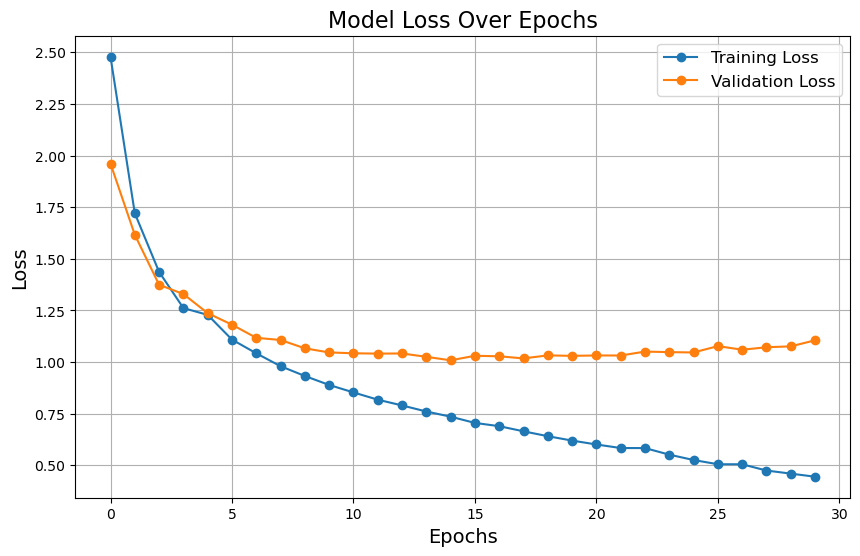

In [9]:
lstm = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
lstm.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

lstm.add(LSTM(100))


lstm.add(Dense(24, activation='softmax'))
lstm.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

lstm_results, lstm_history = runModel(
    model_name="LSTM", 
    model=lstm, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(lstm_history)

## SimpleRNN

Epoch 1/30
83/83 [==============================] - 5s 52ms/step - loss: 2.6827 - accuracy: 0.2358 - val_loss: 2.4117 - val_accuracy: 0.3251
Epoch 2/30
83/83 [==============================] - 4s 51ms/step - loss: 2.1939 - accuracy: 0.3725 - val_loss: 2.0701 - val_accuracy: 0.4239
Epoch 3/30
83/83 [==============================] - 5s 55ms/step - loss: 1.9845 - accuracy: 0.4332 - val_loss: 2.0567 - val_accuracy: 0.4032
Epoch 4/30
83/83 [==============================] - 5s 55ms/step - loss: 1.9973 - accuracy: 0.4291 - val_loss: 2.1319 - val_accuracy: 0.3982
Epoch 5/30
83/83 [==============================] - 5s 56ms/step - loss: 1.8532 - accuracy: 0.4741 - val_loss: 1.9356 - val_accuracy: 0.4546
Epoch 6/30
83/83 [==============================] - 5s 58ms/step - loss: 1.7382 - accuracy: 0.5044 - val_loss: 1.7651 - val_accuracy: 0.5038
Epoch 7/30
83/83 [==============================] - 5s 55ms/step - loss: 1.6307 - accuracy: 0.5317 - val_loss: 1.7348 - val_accuracy: 0.4985
Epoch 8/30
83

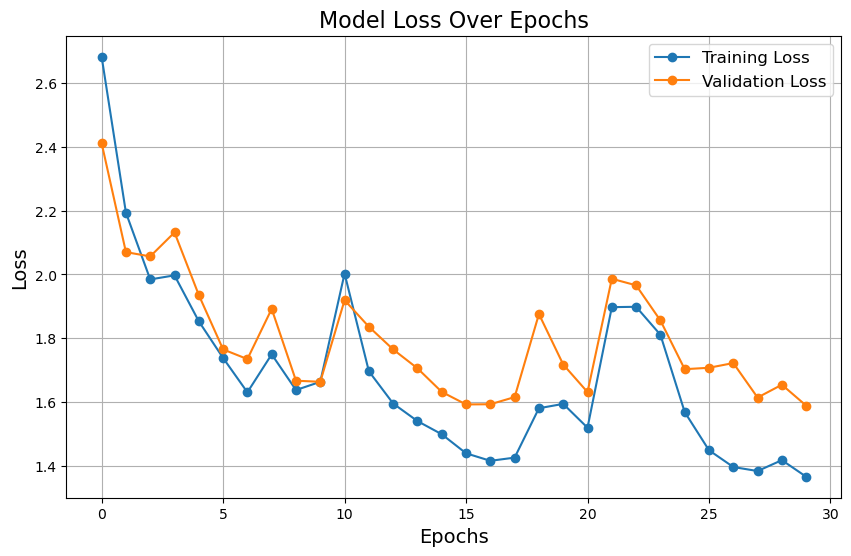

In [10]:
rnn = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
rnn.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

rnn.add(SimpleRNN(100))

rnn.add(Dense(24, activation='softmax'))
rnn.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

rnn_results, rnn_history = runModel(
    model_name="RNN", 
    model=rnn, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(rnn_history)

## GRU

Epoch 1/30
83/83 [==============================] - 2s 13ms/step - loss: 2.5946 - accuracy: 0.2818 - val_loss: 2.1139 - val_accuracy: 0.4149
Epoch 2/30
83/83 [==============================] - 1s 10ms/step - loss: 1.7140 - accuracy: 0.5267 - val_loss: 1.4069 - val_accuracy: 0.6143
Epoch 3/30
83/83 [==============================] - 1s 11ms/step - loss: 1.2321 - accuracy: 0.6495 - val_loss: 1.1839 - val_accuracy: 0.6576
Epoch 4/30
83/83 [==============================] - 1s 10ms/step - loss: 1.0673 - accuracy: 0.6859 - val_loss: 1.0771 - val_accuracy: 0.6874
Epoch 5/30
83/83 [==============================] - 1s 10ms/step - loss: 0.9799 - accuracy: 0.7061 - val_loss: 1.0234 - val_accuracy: 0.7024
Epoch 6/30
83/83 [==============================] - 1s 10ms/step - loss: 0.9231 - accuracy: 0.7197 - val_loss: 0.9915 - val_accuracy: 0.7085
Epoch 7/30
83/83 [==============================] - 1s 10ms/step - loss: 0.8720 - accuracy: 0.7348 - val_loss: 0.9684 - val_accuracy: 0.7108
Epoch 8/30
83

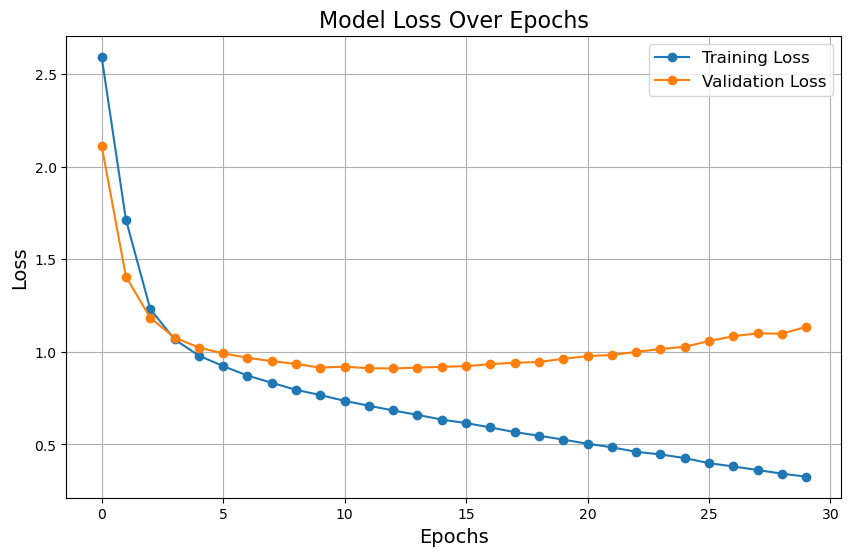

In [11]:
gru = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru.add(GRU(100))

gru.add(Dense(24, activation='softmax'))
gru.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_results, gru_history = runModel(
    model_name="GRU", 
    model=gru, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_history)

## LSTM-Drop

Epoch 1/30
83/83 [==============================] - 2s 15ms/step - loss: 2.5486 - accuracy: 0.3010 - val_loss: 2.0443 - val_accuracy: 0.4567
Epoch 2/30
83/83 [==============================] - 1s 11ms/step - loss: 1.8495 - accuracy: 0.5030 - val_loss: 1.6172 - val_accuracy: 0.5602
Epoch 3/30
83/83 [==============================] - 1s 12ms/step - loss: 1.5445 - accuracy: 0.5774 - val_loss: 1.4219 - val_accuracy: 0.6137
Epoch 4/30
83/83 [==============================] - 1s 11ms/step - loss: 1.3755 - accuracy: 0.6169 - val_loss: 1.3072 - val_accuracy: 0.6348
Epoch 5/30
83/83 [==============================] - 1s 12ms/step - loss: 1.2901 - accuracy: 0.6390 - val_loss: 1.2821 - val_accuracy: 0.6375
Epoch 6/30
83/83 [==============================] - 1s 12ms/step - loss: 1.2457 - accuracy: 0.6458 - val_loss: 1.2070 - val_accuracy: 0.6599
Epoch 7/30
83/83 [==============================] - 1s 12ms/step - loss: 1.1696 - accuracy: 0.6670 - val_loss: 1.2153 - val_accuracy: 0.6578
Epoch 8/30
83

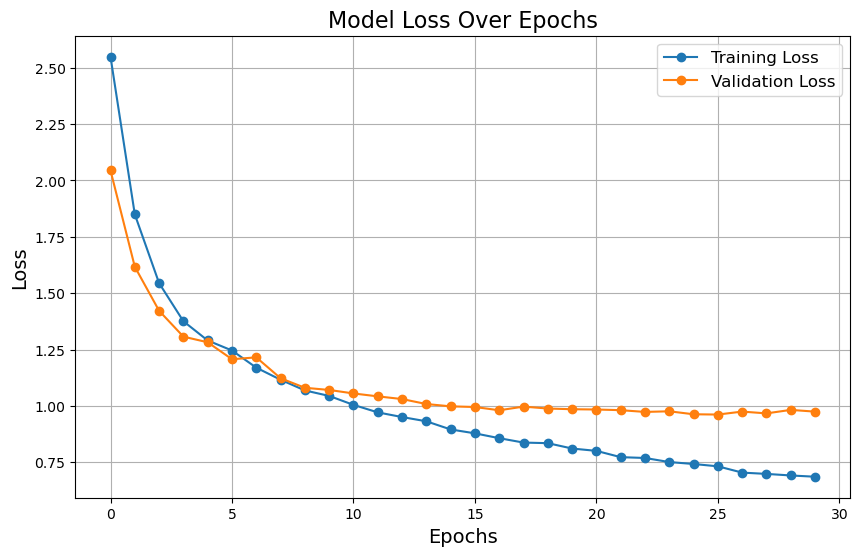

In [12]:
lstm_drop = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
lstm_drop.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

lstm_drop.add(Dropout(0.2))
lstm_drop.add(LSTM(100))
lstm_drop.add(Dropout(0.2))

lstm_drop.add(Dense(24, activation='softmax'))
lstm_drop.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

lstm_drop_results, lstm_drop_history = runModel(
    model_name="LSTM Dropout", 
    model=lstm_drop, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(lstm_drop_history)

## SimpleRNN Dropout

Epoch 1/30
83/83 [==============================] - 5s 53ms/step - loss: 2.8214 - accuracy: 0.1948 - val_loss: 2.5218 - val_accuracy: 0.2936
Epoch 2/30
83/83 [==============================] - 4s 54ms/step - loss: 2.3621 - accuracy: 0.3255 - val_loss: 2.2516 - val_accuracy: 0.3678
Epoch 3/30
83/83 [==============================] - 5s 55ms/step - loss: 2.3525 - accuracy: 0.3325 - val_loss: 2.4814 - val_accuracy: 0.2997
Epoch 4/30
83/83 [==============================] - 4s 53ms/step - loss: 2.3115 - accuracy: 0.3434 - val_loss: 2.8564 - val_accuracy: 0.2068
Epoch 5/30
83/83 [==============================] - 5s 55ms/step - loss: 2.4012 - accuracy: 0.3219 - val_loss: 2.2168 - val_accuracy: 0.3787
Epoch 6/30
83/83 [==============================] - 5s 58ms/step - loss: 2.1670 - accuracy: 0.3834 - val_loss: 2.1031 - val_accuracy: 0.4081
Epoch 7/30
83/83 [==============================] - 5s 57ms/step - loss: 2.0156 - accuracy: 0.4260 - val_loss: 1.9585 - val_accuracy: 0.4487
Epoch 8/30
83

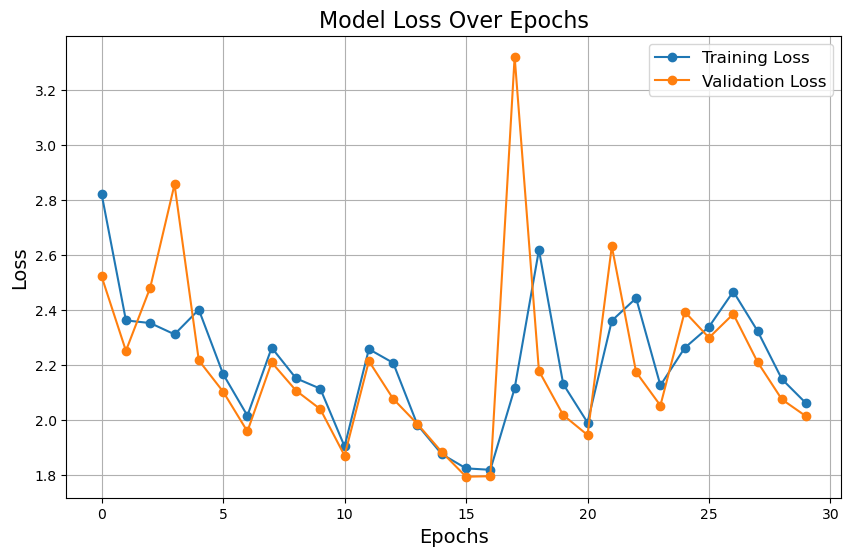

In [13]:
rnn_drop = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
rnn_drop.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

rnn_drop.add(Dropout(0.2))
rnn_drop.add(SimpleRNN(100))
rnn_drop.add(Dropout(0.2))

rnn_drop.add(Dense(24, activation='softmax'))
rnn_drop.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

rnn_drop_results, rnn_drop_history = runModel(
    model_name="RNN Dropout", 
    model=rnn_drop, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(rnn_drop_history)

## GRU Dropout

Epoch 1/30
83/83 [==============================] - 2s 15ms/step - loss: 2.6684 - accuracy: 0.2581 - val_loss: 2.1741 - val_accuracy: 0.4107
Epoch 2/30
83/83 [==============================] - 1s 11ms/step - loss: 1.8653 - accuracy: 0.4838 - val_loss: 1.5244 - val_accuracy: 0.5748
Epoch 3/30
83/83 [==============================] - 1s 11ms/step - loss: 1.3906 - accuracy: 0.6088 - val_loss: 1.2584 - val_accuracy: 0.6451
Epoch 4/30
83/83 [==============================] - 1s 11ms/step - loss: 1.1953 - accuracy: 0.6551 - val_loss: 1.1265 - val_accuracy: 0.6730
Epoch 5/30
83/83 [==============================] - 1s 11ms/step - loss: 1.0956 - accuracy: 0.6775 - val_loss: 1.0653 - val_accuracy: 0.6903
Epoch 6/30
83/83 [==============================] - 1s 11ms/step - loss: 1.0337 - accuracy: 0.6934 - val_loss: 1.0206 - val_accuracy: 0.6962
Epoch 7/30
83/83 [==============================] - 1s 11ms/step - loss: 0.9830 - accuracy: 0.7061 - val_loss: 0.9861 - val_accuracy: 0.7070
Epoch 8/30
83

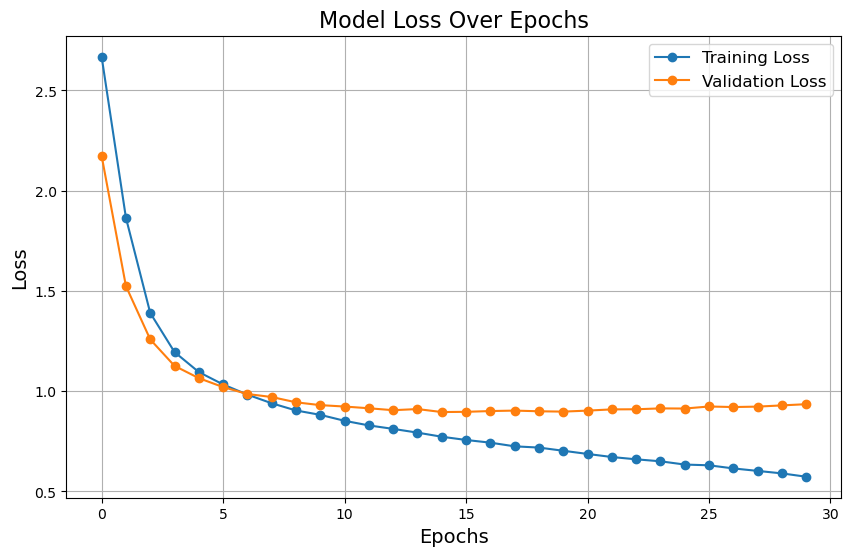

In [14]:
gru_drop = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_drop.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_drop.add(Dropout(0.2))
gru_drop.add(GRU(100))
gru_drop.add(Dropout(0.2))

gru_drop.add(Dense(24, activation='softmax'))
gru_drop.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_drop_results, gru_drop_history = runModel(
    model_name="GRU Dropout", 
    model=gru_drop, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_drop_history)

## Bi-LSTM

Epoch 1/50
83/83 [==============================] - 3s 25ms/step - loss: 2.5589 - accuracy: 0.2834 - val_loss: 2.0379 - val_accuracy: 0.4778
Epoch 2/50
83/83 [==============================] - 2s 20ms/step - loss: 1.7275 - accuracy: 0.5335 - val_loss: 1.5792 - val_accuracy: 0.5750
Epoch 3/50
83/83 [==============================] - 2s 19ms/step - loss: 1.4381 - accuracy: 0.6019 - val_loss: 1.4238 - val_accuracy: 0.6082
Epoch 4/50
83/83 [==============================] - 2s 20ms/step - loss: 1.3280 - accuracy: 0.6265 - val_loss: 1.3098 - val_accuracy: 0.6381
Epoch 5/50
83/83 [==============================] - 2s 20ms/step - loss: 1.2562 - accuracy: 0.6405 - val_loss: 1.4477 - val_accuracy: 0.6018
Epoch 6/50
83/83 [==============================] - 2s 20ms/step - loss: 1.2196 - accuracy: 0.6484 - val_loss: 1.2446 - val_accuracy: 0.6369
Epoch 7/50
83/83 [==============================] - 2s 20ms/step - loss: 1.1137 - accuracy: 0.6742 - val_loss: 1.2061 - val_accuracy: 0.6512
Epoch 8/50
83

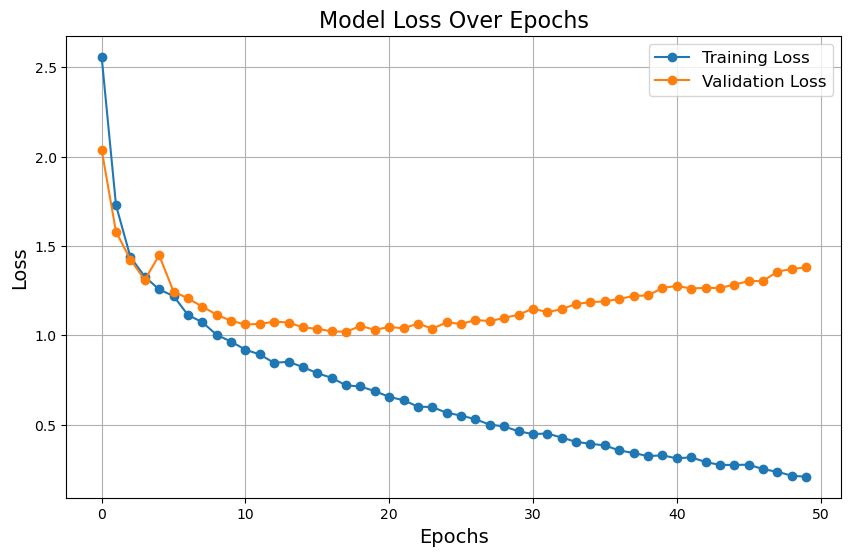

In [15]:
lstm_bi = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
lstm_bi.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

lstm_bi.add(Bidirectional(LSTM(100)))

lstm_bi.add(Dense(24, activation='softmax'))
lstm_bi.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

lstm_bi_results, lstm_bi_history = runModel(
    model_name="Bi-LSTM", 
    model=lstm_bi, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder,
    epochs = 50
)

plot_loss(lstm_bi_history)

## Bi-SimpleRNN

Epoch 1/50
83/83 [==============================] - 10s 118ms/step - loss: 2.7768 - accuracy: 0.2065 - val_loss: 2.6148 - val_accuracy: 0.2704
Epoch 2/50
83/83 [==============================] - 10s 114ms/step - loss: 2.3270 - accuracy: 0.3342 - val_loss: 2.2033 - val_accuracy: 0.3775
Epoch 3/50
83/83 [==============================] - 9s 114ms/step - loss: 2.1297 - accuracy: 0.3924 - val_loss: 2.0115 - val_accuracy: 0.4294
Epoch 4/50
83/83 [==============================] - 9s 111ms/step - loss: 1.9844 - accuracy: 0.4324 - val_loss: 2.1524 - val_accuracy: 0.4022
Epoch 5/50
83/83 [==============================] - 9s 114ms/step - loss: 1.9013 - accuracy: 0.4578 - val_loss: 1.8608 - val_accuracy: 0.4728
Epoch 6/50
83/83 [==============================] - 9s 113ms/step - loss: 1.9314 - accuracy: 0.4455 - val_loss: 2.1074 - val_accuracy: 0.3992
Epoch 7/50
83/83 [==============================] - 10s 116ms/step - loss: 1.9502 - accuracy: 0.4382 - val_loss: 1.8942 - val_accuracy: 0.4504
Epo

C:\Users\nicol\miniconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


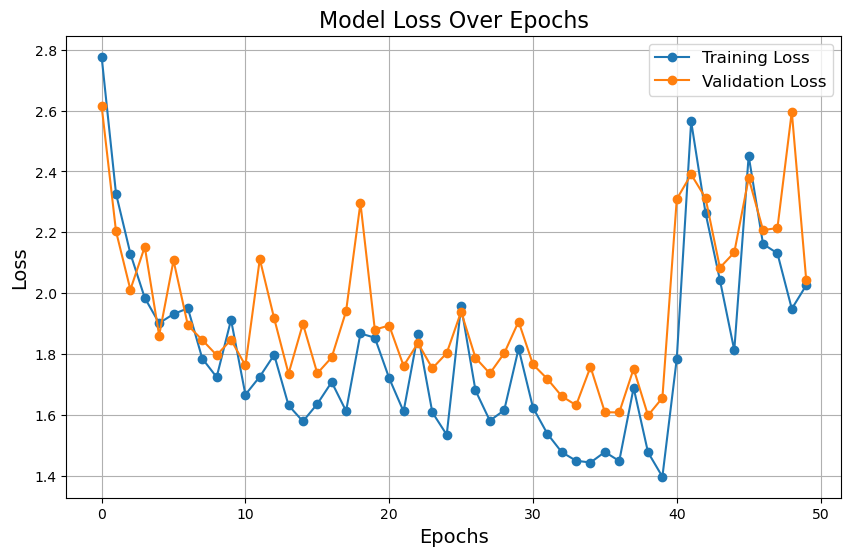

In [16]:
rnn_bi = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
rnn_bi.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

rnn_bi.add(Bidirectional(SimpleRNN(100)))

rnn_bi.add(Dense(24, activation='softmax'))
rnn_bi.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

rnn_bi_results, rnn_bi_history = runModel(
    model_name="Bi-RNN", 
    model=rnn_bi, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder, 
    epochs=50
)

plot_loss(rnn_bi_history)

## Bi-GRU

Epoch 1/50
83/83 [==============================] - 4s 26ms/step - loss: 2.6296 - accuracy: 0.2669 - val_loss: 2.1737 - val_accuracy: 0.3994
Epoch 2/50
83/83 [==============================] - 2s 18ms/step - loss: 1.8219 - accuracy: 0.4938 - val_loss: 1.5521 - val_accuracy: 0.5720
Epoch 3/50
83/83 [==============================] - 2s 18ms/step - loss: 1.3330 - accuracy: 0.6296 - val_loss: 1.2304 - val_accuracy: 0.6532
Epoch 4/50
83/83 [==============================] - 2s 18ms/step - loss: 1.1069 - accuracy: 0.6782 - val_loss: 1.1077 - val_accuracy: 0.6804
Epoch 5/50
83/83 [==============================] - 2s 18ms/step - loss: 1.0021 - accuracy: 0.7021 - val_loss: 1.0464 - val_accuracy: 0.6924
Epoch 6/50
83/83 [==============================] - 1s 18ms/step - loss: 0.9353 - accuracy: 0.7196 - val_loss: 1.0097 - val_accuracy: 0.7000
Epoch 7/50
83/83 [==============================] - 1s 18ms/step - loss: 0.8795 - accuracy: 0.7328 - val_loss: 0.9773 - val_accuracy: 0.7053
Epoch 8/50
83

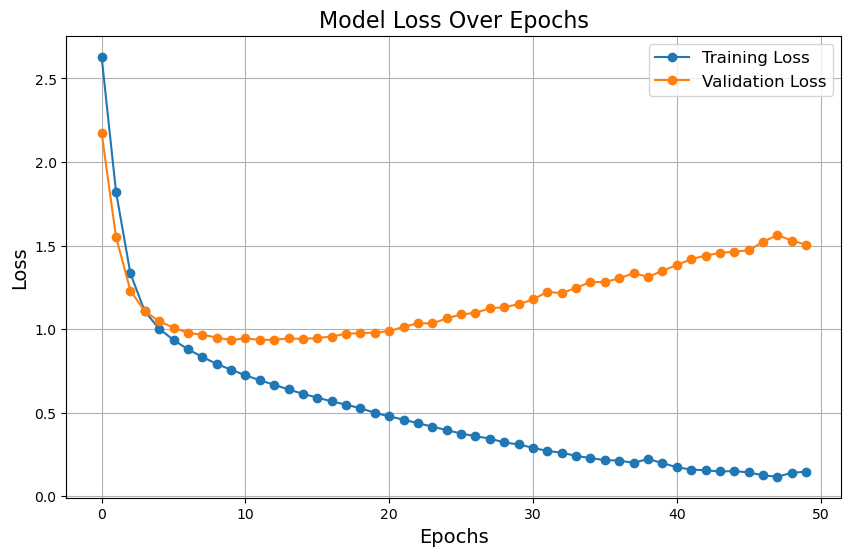

In [17]:
gru_bi = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_bi.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_bi.add(Bidirectional(GRU(100)))

gru_bi.add(Dense(24, activation='softmax'))
gru_bi.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_bi_results, gru_bi_history = runModel(
    model_name="Bi-GRU", 
    model=gru_bi, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder, 
    epochs=50
)

plot_loss(gru_bi_history)

## CNN-LSTM

Epoch 1/30
83/83 [==============================] - 4s 12ms/step - loss: 2.6671 - accuracy: 0.2450 - val_loss: 2.1515 - val_accuracy: 0.4083
Epoch 2/30
83/83 [==============================] - 1s 8ms/step - loss: 1.8078 - accuracy: 0.4964 - val_loss: 1.6191 - val_accuracy: 0.5543
Epoch 3/30
83/83 [==============================] - 1s 8ms/step - loss: 1.4692 - accuracy: 0.5848 - val_loss: 1.4071 - val_accuracy: 0.6044
Epoch 4/30
83/83 [==============================] - 1s 8ms/step - loss: 1.2814 - accuracy: 0.6312 - val_loss: 1.2983 - val_accuracy: 0.6365
Epoch 5/30
83/83 [==============================] - 1s 8ms/step - loss: 1.1681 - accuracy: 0.6579 - val_loss: 1.2233 - val_accuracy: 0.6441
Epoch 6/30
83/83 [==============================] - 1s 8ms/step - loss: 1.0908 - accuracy: 0.6764 - val_loss: 1.1623 - val_accuracy: 0.6662
Epoch 7/30
83/83 [==============================] - 1s 9ms/step - loss: 1.0295 - accuracy: 0.6936 - val_loss: 1.1333 - val_accuracy: 0.6669
Epoch 8/30
83/83 [=

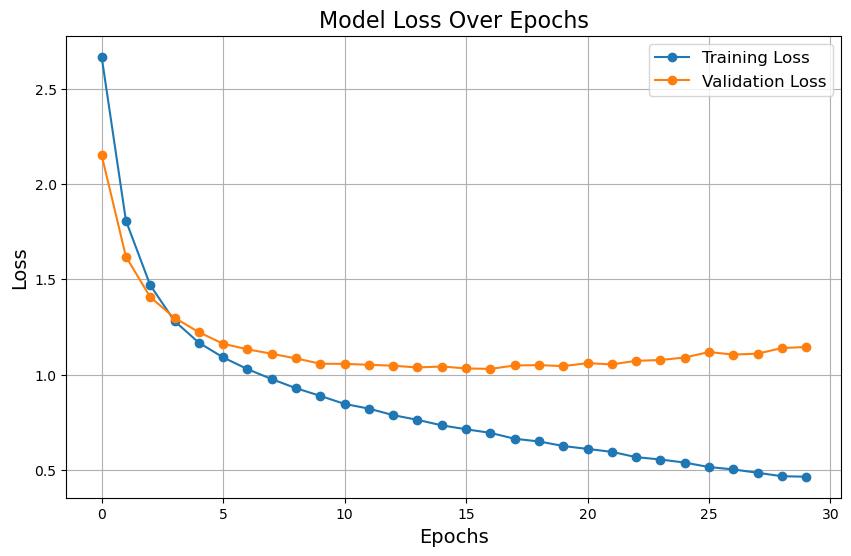

In [18]:
lstm_cnn = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
lstm_cnn.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

lstm_cnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
lstm_cnn.add(MaxPooling1D(pool_size=2))
lstm_cnn.add(LSTM(100))

lstm_cnn.add(Dense(24, activation='softmax'))
lstm_cnn.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

lstm_cnn_results, lstm_cnn_history = runModel(
    model_name="LSTM-CNN", 
    model=lstm_cnn, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(lstm_cnn_history)

## CNN-SimpleRNN

Epoch 1/30
83/83 [==============================] - 4s 38ms/step - loss: 2.6230 - accuracy: 0.2636 - val_loss: 2.3232 - val_accuracy: 0.3416
Epoch 2/30
83/83 [==============================] - 3s 37ms/step - loss: 2.0881 - accuracy: 0.4104 - val_loss: 2.0177 - val_accuracy: 0.4326
Epoch 3/30
83/83 [==============================] - 3s 38ms/step - loss: 1.8421 - accuracy: 0.4832 - val_loss: 1.8696 - val_accuracy: 0.4630
Epoch 4/30
83/83 [==============================] - 3s 35ms/step - loss: 1.6897 - accuracy: 0.5242 - val_loss: 1.7019 - val_accuracy: 0.5177
Epoch 5/30
83/83 [==============================] - 3s 37ms/step - loss: 1.6975 - accuracy: 0.5198 - val_loss: 1.6598 - val_accuracy: 0.5289
Epoch 6/30
83/83 [==============================] - 3s 37ms/step - loss: 1.4670 - accuracy: 0.5838 - val_loss: 1.5538 - val_accuracy: 0.5480
Epoch 7/30
83/83 [==============================] - 3s 39ms/step - loss: 1.3718 - accuracy: 0.6040 - val_loss: 1.4938 - val_accuracy: 0.5741
Epoch 8/30
83

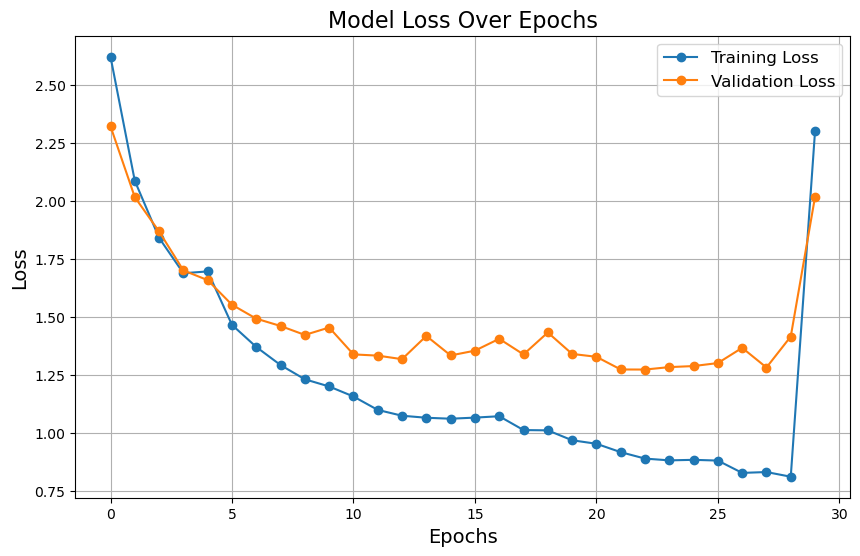

In [19]:
rnn_cnn = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
rnn_cnn.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

rnn_cnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
rnn_cnn.add(MaxPooling1D(pool_size=2))
rnn_cnn.add(SimpleRNN(100))

rnn_cnn.add(Dense(24, activation='softmax'))
rnn_cnn.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

rnn_cnn_results, rnn_cnn_history = runModel(
    model_name="RNN-CNN", 
    model=rnn_cnn, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(rnn_cnn_history)

## CNN-GRU

Epoch 1/30
83/83 [==============================] - 2s 11ms/step - loss: 2.6753 - accuracy: 0.2365 - val_loss: 2.1244 - val_accuracy: 0.4045
Epoch 2/30
83/83 [==============================] - 1s 8ms/step - loss: 1.6688 - accuracy: 0.5263 - val_loss: 1.4461 - val_accuracy: 0.5864
Epoch 3/30
83/83 [==============================] - 1s 8ms/step - loss: 1.2713 - accuracy: 0.6372 - val_loss: 1.2338 - val_accuracy: 0.6426
Epoch 4/30
83/83 [==============================] - 1s 8ms/step - loss: 1.1052 - accuracy: 0.6780 - val_loss: 1.1457 - val_accuracy: 0.6624
Epoch 5/30
83/83 [==============================] - 1s 8ms/step - loss: 1.0095 - accuracy: 0.6988 - val_loss: 1.0791 - val_accuracy: 0.6823
Epoch 6/30
83/83 [==============================] - 1s 8ms/step - loss: 0.9415 - accuracy: 0.7164 - val_loss: 1.0644 - val_accuracy: 0.6865
Epoch 7/30
83/83 [==============================] - 1s 8ms/step - loss: 0.8934 - accuracy: 0.7275 - val_loss: 1.0160 - val_accuracy: 0.6946
Epoch 8/30
83/83 [=

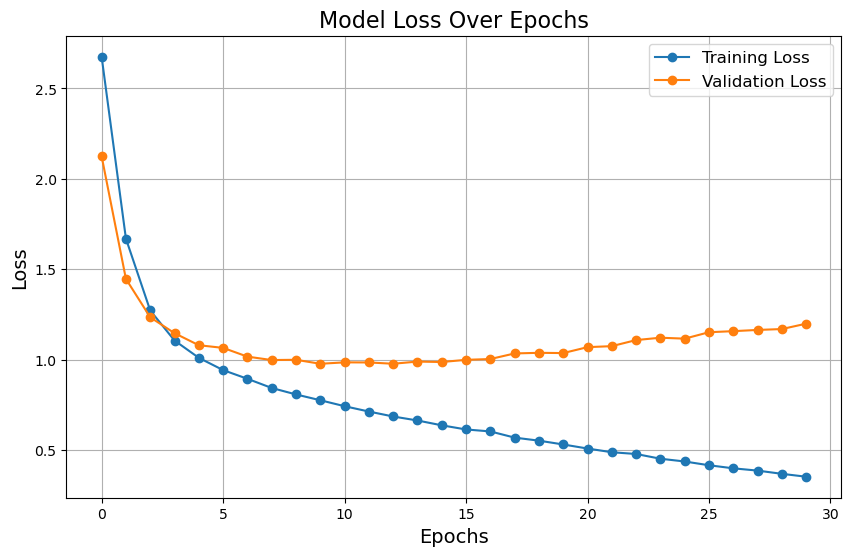

In [20]:
gru_cnn = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_cnn.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_cnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
gru_cnn.add(MaxPooling1D(pool_size=2))
gru_cnn.add(GRU(100))

gru_cnn.add(Dense(24, activation='softmax'))
gru_cnn.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_cnn_results, gru_cnn_history = runModel(
    model_name="GRU-CNN", 
    model=gru_cnn, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_cnn_history)

# Summary

In [21]:
summary = pd.concat([lstm_results, rnn_results, gru_results, 
                     lstm_bi_results, rnn_bi_results, gru_bi_results,
                     lstm_cnn_results, rnn_cnn_results, gru_cnn_results,
                     lstm_drop_results, rnn_drop_results, gru_drop_results])
summary.sort_values('F1', ascending=False)

,Model,Accuracy,Precision,Recall,F1,Training_Time
0,GRU Dropout,0.729586,0.726041,0.710642,0.716340,28.970879
0,LSTM Dropout,0.718762,0.702777,0.687737,0.692779,30.546485
0,GRU,0.712115,0.696554,0.686417,0.689518,25.868961
0,Bi-GRU,0.707368,0.698221,0.680986,0.688327,77.630335
0,LSTM,0.709457,0.693804,0.672727,0.680631,36.414390
0,GRU-CNN,0.701671,0.689893,0.672792,0.679049,20.042834
0,Bi-LSTM,0.697493,0.692636,0.665874,0.677193,88.090431
0,LSTM-CNN,0.695594,0.692878,0.644972,0.662430,23.483847
0,RNN,0.544816,0.564332,0.459206,0.482380,140.491668
0,RNN-CNN,0.437904,0.458739,0.354089,0.370217,93.654511
